In [1]:
# Imports

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tensorflow as tf
import numpy as np
import pandas as pd
from itertools import *
import sklearn
import math
import random
import sys
import multiprocessing
import scipy
from joblib import Parallel, delayed
import threading
nproc = max(1, multiprocessing.cpu_count() - 1)

if 'utils' not in sys.path:
    sys.path.append('utils')

import data_loader
from tf_gmm_em import *

# Warnings

import warnings
warnings.filterwarnings('ignore')

# Idempotent, cached data retrieval script

train_df, test_df, train_ix, test_ix, train_tissues, tfs = \
    data_loader.load_chromosome_cached('1')
    
train_df_int = train_df
for i in train_tissues:
    train_df_int[i] = data_loader.local_impute(train_df[i].copy())
print('nans in interpolated', np.isnan(train_df_int[train_tissues]).sum().sum())

nans in interpolated 0


In [2]:
# Verify that we get similar likelihoods with e step.

# Make sure N, D are small so the numerically unstable verification code
# doesn't underflow.
N = 5
D = 10

X = np.random.normal(size=(N, D))
mu = X.mean(axis=0)
sigma = X.std(axis=0)
mus = np.array([mu, mu, mu * 2])
sigmas = np.array([sigma, sigma * 2, sigma])
K = len(sigmas)
alphas = np.random.dirichlet(np.ones(K), 1)[0]

with tf.Session() as sess:
    mean_ll, resp = sess.run(estep(*(tf.constant(x) for x in (X, mus, sigmas, alphas))))
def normal_likelihoods(X, mu, sigma):
    exponent = -np.dot((X - mu[np.newaxis, :]) ** 2, 1 / sigma) / 2
    return (2 * np.pi) ** (-D / 2) * np.prod(sigma) ** (-1 / 2) * np.exp(exponent)
actual = np.array([normal_likelihoods(X, mu, sigma) for mu, sigma in zip(mus, sigmas)])
actual = sklearn.preprocessing.normalize(actual * alphas[:, np.newaxis], norm='l1', axis=0)
resp = sklearn.preprocessing.normalize(resp, norm='l1', axis=0)
print('actual likelihoods', actual)
print('log likelihoods   ', resp)
rmses = np.sqrt(sklearn.metrics.mean_squared_error(actual.T, resp.T, multioutput='raw_values'))
for i, rmse in enumerate(rmses):
    print('K={} rmse={}'.format(i, rmse))

actual likelihoods [[ 0.62538449  0.54523774  0.60606044  0.50841656  0.36889884]
 [ 0.25914281  0.25810876  0.31521413  0.39260545  0.61973193]
 [ 0.1154727   0.1966535   0.07872543  0.09897798  0.01136924]]
log likelihoods    [[ 0.62538449  0.54523774  0.60606044  0.50841656  0.36889884]
 [ 0.25914281  0.25810876  0.31521413  0.39260545  0.61973193]
 [ 0.1154727   0.1966535   0.07872543  0.09897798  0.01136924]]
K=0 rmse=2.3288234633381846e-16
K=1 rmse=3.050589040050974e-16
K=2 rmse=1.11465938984643e-16


EM iteration 0 log likelihood -7.35198152992
EM iteration 1 log likelihood -6.47467678494
EM iteration 2 log likelihood -6.24674774385
EM iteration 3 log likelihood -5.97248623094
EM iteration 4 log likelihood -5.76790958396
EM iteration 5 log likelihood -5.58112689263
EM iteration 6 log likelihood -5.33878066436
EM iteration 7 log likelihood -5.15980763038
EM iteration 8 log likelihood -4.99778837824
EM iteration 9 log likelihood -4.92989800906
EM iteration 10 log likelihood -4.89466501232
EM iteration 11 log likelihood -4.89062020699
EM iteration 12 log likelihood -4.89026156177
EM iteration 13 log likelihood -4.89018691658
EM iteration 14 log likelihood -4.89016792669
EM iteration 15 log likelihood -4.89016267811
EM iteration 16 log likelihood -4.89016116864
EM iteration 17 log likelihood -4.89016072562
EM iteration 18 log likelihood -4.89016059419
EM iteration 19 log likelihood -4.89016055498
EM iteration 20 log likelihood -4.89016054324
EM iteration 21 log likelihood -4.8901605397

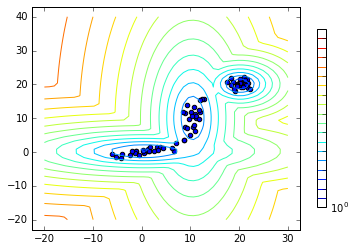

In [3]:
# Check that EM is working on small 2D example

n_samples = 25
np.random.seed(0)

def MVN(shear, shift):
    rs = np.random.randn(n_samples, 2)
    return np.dot(rs, shear.T) + shift
G1 = MVN(np.identity(2), np.array([20, 20]))
G2 = MVN(np.array([[0., 3.5], [-0.7, .7]]), np.zeros(2))
G3 = MVN(np.array([[-1, 0.8], [0, 4]]), np.array([10, 8]))

# concatenate the two datasets into the final training set
X = np.vstack([G1, G2, G3])
rx = np.random.choice(range(len(X)), 3, replace=False)

# http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html
_, m, s, a = fit_em(X, X[rx], 100, EPS)
x = np.linspace(-20.0, 30.0)
y = np.linspace(-20.0, 40.0)
xx, yy = np.meshgrid(x, y)
pts = np.array([xx.ravel(), yy.ravel()]).T
with tf.Session() as sess:
    ll = sess.run(-estep(pts, m, s, a)[0])
print('means\n{}\ncov\n{}\ncluster priors\n{}'.format(m, s, a))
CS = plt.contour(xx, yy, ll.reshape(xx.shape), norm=LogNorm(vmin=1.0, vmax=1000.0),
                levels=np.logspace(0, 3, 20))
plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X[:, 0], X[:, 1])
plt.show()

y = -10.0
y = 0.0
y = 2.5
y = 10.0
y = 20.0


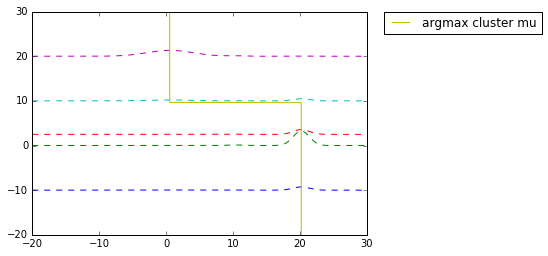

In [4]:
# Make this into a nice image.
ys = [-10, 0, 2.5, 10, 20]
pts = np.arange(-20, 30, 0.1, dtype='float64').reshape(-1, 1)
ys = np.array(ys, dtype='float64').reshape(-1, 1)
# Reverse m, s, a, since we know 'y'
mr, sr = (x[:, ::-1] for x in (m, s))
mm, sm, ams = marginal_posterior(ys, mr, sr, a)
with tf.Session() as sess:
    for i, y in enumerate(ys.reshape(-1)):
        print('y =', y)
        ll = sess.run(estep(pts, mm, sm, ams[i])[0]).reshape(-1)
        plt.plot(pts, np.exp(ll) / 10 + y, ls='--')

ys = np.arange(-20, 30, 0.05, dtype='float64').reshape(-1, 1)
mm, sm, ams = marginal_posterior(ys, mr, sr, a)
xs = [argmax_exp(mm, sm, am) for am in ams]
plt.plot(xs, ys, label='argmax cluster mu')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [5]:
## Implement custom GMM

tissues_to_cluster = train_tissues[:-1] # note this contains bad tissues 25, 26 still.
X_np = train_df_int[tissues_to_cluster].values.transpose()
N = len(tissues_to_cluster)

np.random.seed(2)
rmu = np.random.choice(range(N), K, replace=False)

mu_init = X_np[rmu]

print(mu_init.shape)

lp, m, s, a = fit_em(X_np, mu_init, 100, EPS)
print('mean log likelihood\n{}\nmeans\n{}\ncov\n{}\ncluster priors\n{}'
      .format(lp, m, s, a))

(3, 379551)
EM iteration 0 log likelihood 196079.78507
EM iteration 1 log likelihood 349194.10917
EM iteration 2 log likelihood 349194.10917
mean log likelihood
349194.1091700783
means
[[ 0.82155828  0.85358269  0.89969972 ...,  0.83770646  0.76792878
   0.90230342]
 [ 0.66285167  0.77419355  0.8371126  ...,  0.77509867  0.67699676
   0.82820652]
 [ 0.67663614  0.72054922  0.78027878 ...,  0.84746755  0.77541948
   0.9193175 ]]
cov
[[ 0.02260282  0.01610682  0.00167859 ...,  0.01114634  0.01686153
   0.00408701]
 [ 0.02323667  0.01974373  0.01764314 ...,  0.01254889  0.0099991
   0.01053107]
 [ 0.07547356  0.07811962  0.08039246 ...,  0.01250176  0.03177511
   0.00101074]]
cluster priors
[ 0.57575758  0.24242424  0.18181818]


In [6]:
o = np.ones(len(train_df))
o[train_ix] = 0
o[test_ix] = 0
unobserved_untested_ix = np.where(o)[0]
o = np.zeros(len(train_df))
o[test_ix] = 1
unobserved_tested_ix = np.where(o)[0]

In [7]:
perm = np.hstack((train_ix, unobserved_tested_ix, unobserved_untested_ix))

In [8]:
observed = test_df['filled'][train_ix].values
len(perm), len(train_df)

(379551, 379551)

In [9]:
mm, ms = (x[:, perm] for x in (m, s))
print(len(mm[0]), len(ms[0]), len(a))
print(observed.reshape(1, len(observed)))
print(observed.shape)
mm, sm, ams = marginal_posterior(observed.reshape(1, len(observed)), mm, ms, a)
print(mm.shape, sm.shape, ams.shape)
pred = argmax_exp(mm, sm, ams[0])[:len(unobserved_tested_ix)]
print(pred)
actual = test_df['filled'][unobserved_tested_ix]
print(len(pred), len(actual))
print('rmse', math.sqrt(actual.sub(pred).pow(2).mean())) # rmse of GMM
print('r2', sklearn.metrics.r2_score(actual, pred))
print('mle')
pred2 = gd_mle(mm, sm, np.exp(ams[0]), 5, EPS, warning='gd', verbose=True, minstep=1e-4)
pred2 = pred2.reshape(-1)[:len(unobserved_tested_ix)]
print('rmse', math.sqrt(actual.sub(pred2).pow(2).mean())) # rmse of GMM
print('r2', sklearn.metrics.r2_score(actual, pred2))

379551 379551 3
[[ 0.6888889   0.8518519   0.14666666 ...,  0.877193    0.9259259
   0.41666666]]
(7523,)
(3, 372028) (3, 372028) (1, 3)
[ 0.82155828  0.85358269  0.89969972 ...,  0.83770646  0.76792878
  0.90230342]
368411 368411
rmse 0.09589186839714639
r2 0.678430496245
mle
Running mean 0
   1 of 5 done, NLL = -568224.639786
   2 of 5 done, NLL = -568224.639786
  Converged early after 2 steps.
  Best NLL = -568224.639786
Running mean 1
   1 of 5 done, NLL = -455890.463927
   2 of 5 done, NLL = -455890.463927
  Converged early after 2 steps.
  Best NLL = -455890.463927
Running mean 2
   1 of 5 done, NLL = -510263.83155
   2 of 5 done, NLL = -510263.83155
  Converged early after 2 steps.
  Best NLL = -510263.83155
rmse 0.09589186839714639
r2 0.678430496245
